## <center> Part 2: Pre-processing and Text Transformations </center>

### Table of Contents

1. [Introduction](#Introduction)
    <br>
    
2. [Grouping similar categories](#Grouping-similar-categories)
    <br>
3. [Understanding word distribution in our categories](#Understanding-word-distribution-in-our-categories)
    <br>
4. [Tokenizers and Vectorizers](#Tokenizers-and-Vectorizers)
   - [Tokenizer - Stemming](#Tokenizer---Stemming)
   - [Tokenizer - Lemmatization](#Tokenizer---Lemmatization)
   - [CountVectorizer on Stemming Tokenizer](#CountVectorizer-on-Stemming-Tokenizer)
   - [CountVectorizer on Lemmatization Tokenizer](#CountVectorizer-on-Lemmatization-Tokenizer)
   - [Sentence2Vec](#Sentence2Vec)
       
       <br>
    
5. [Summary](#Summary)


## Introduction

In the second notebook of our project, we delve into the critical phase of data preprocessing, with a specific emphasis on text data. This stage involves the application of advanced techniques, including text vectorization, tokenization, and word embeddings.These processes enable us to represent and process text data effectively, facilitating the development of our models.

As our first step, we will import the necessary libraries and packages.

In [43]:
# Importing necessary libraries and packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE

from my_functions import lem_tokenizer, stem_tokenizer, remove_html_tags, ENGLISH_STOP_WORDS, sentence2vec #importing custom functions that I have created

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import LabelEncoder

In [44]:
# Reading the data from the cleaned categories csv file and writing it into a dataframe

df_categories = pd.read_csv('cleaned_categories.csv')


# Setting the index to begin from 1
df_categories.reset_index(drop=True, inplace=True)
df_categories.index += 1

Let's have our first look into our dataset:

In [45]:
# Sanity check

df_categories.head(10)

,link,headline,category,short_description,authors,date,month_num,year,article_text
1,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,9,2022,Over 4 Million Americans Roll Up Sleeves For O...
2,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,9,2022,"American Airlines Flyer Charged, Banned For Li..."
3,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,9,2022,23 Of The Funniest Tweets About Cats And Dogs ...
4,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,9,2022,The Funniest Tweets From Parents This Week (Se...
5,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,9,2022,Woman Who Called Cops On Black Bird-Watcher Lo...
6,https://www.huffpost.com/entry/belk-worker-fou...,Cleaner Was Dead In Belk Bathroom For 4 Days B...,U.S. NEWS,The 63-year-old woman was seen working at the ...,NaN,2022-09-22,9,2022,Cleaner Was Dead In Belk Bathroom For 4 Days B...
7,https://www.huffpost.com/entry/reporter-gets-a...,Reporter Gets Adorable Surprise From Her Boyfr...,U.S. NEWS,"""Who's that behind you?"" an anchor for New Yor...",Elyse Wanshel,2022-09-22,9,2022,Reporter Gets Adorable Surprise From Her Boyfr...
8,https://www.huffpost.com/entry/puerto-rico-wat...,Puerto Ricans Desperate For Water After Hurric...,WORLD NEWS,More than half a million people remained witho...,"DÁNICA COTO, AP",2022-09-22,9,2022,Puerto Ricans Desperate For Water After Hurric...
9,https://www.huffpost.com/entry/mija-documentar...,How A New Documentary Captures The Complexity ...,CULTURE & ARTS,"In ""Mija,"" director Isabel Castro combined mus...",Marina Fang,2022-09-22,9,2022,How A New Documentary Captures The Complexity ...
10,https://www.huffpost.com/entry/biden-un-russia...,Biden At UN To Call Russian War An Affront To ...,WORLD NEWS,White House officials say the crux of the pres...,"Aamer Madhani, AP",2022-09-21,9,2022,Biden At UN To Call Russian War An Affront To ...


In [46]:
df_categories.shape

(189801, 9)

Let's begin by analyzing our category distribution:

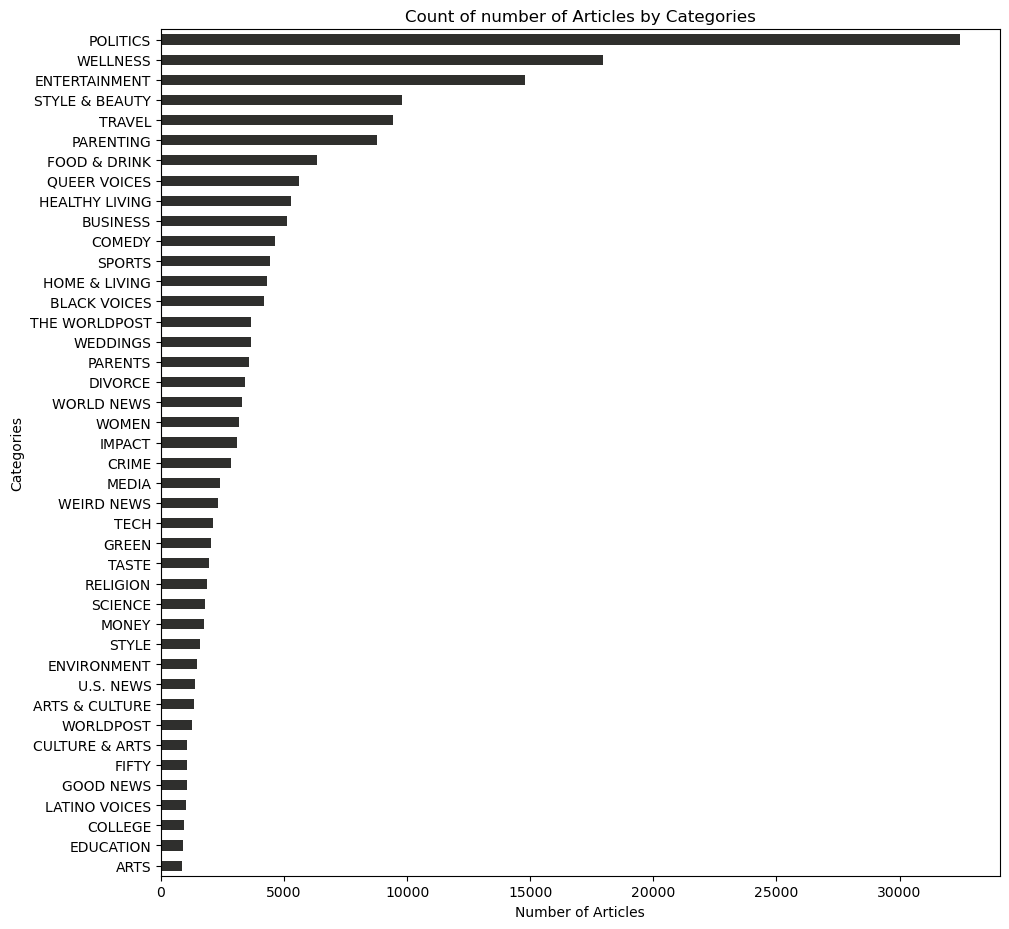

In [47]:
# Plot horizontal bar charts to visualize the count of each category:

plt.figure(figsize=(10, 9))
df_categories["category"].value_counts().sort_values().plot(kind="barh", color="#2F2F2D")
plt.tight_layout()
plt.xlabel("Number of Articles")
plt.ylabel("Categories")
plt.title("Count of number of Articles by Categories")
plt.show()

In [36]:
# How many unique categories are there?

df_categories.groupby("category").ngroups

42

As we can see, there are categories that mean similar themes and can be grouped. Example: `SCIENCE` and `TECH` can be grouped to form `SCIENCE AND TECH`. Also, we can confirm that there are 42 groups in total in the current dataframe. Let's combine the groups that share similar themes in the following section: 

## Grouping similar categories

In [37]:
# Comibining categories that share similar themes

df_categories["category"] = df_categories["category"].replace(
    {
        "HEALTHY LIVING": "WELLNESS",
        "QUEER VOICES": "GROUPS VOICES",
        "BLACK VOICES": "GROUPS VOICES",
        "LATINO VOICES": "GROUPS VOICES",
        "BUSINESS": "BUSINESS & FINANCES",
        "MONEY": "BUSINESS & FINANCES",
        "PARENTS": "PARENTING",
        "THE WORLDPOST": "WORLD NEWS",
        "WORLDPOST": "WORLD NEWS",
        "U.S. NEWS": "WORLD NEWS",
        "WEIRD NEWS": "WORLD NEWS",
        "IMPACT": "WORLD NEWS",
        "STYLE": "STYLE & BEAUTY",
        "GREEN": "ENVIRONMENT",
        "TASTE": "FOOD & DRINK",
        "SCIENCE": "SCIENCE & TECH",
        "TECH": "SCIENCE & TECH",
        "CULTURE & ARTS": "ARTS & CULTURE",
        "ARTS": "ARTS & CULTURE",
        "COLLEGE": "EDUCATION",
        "DIVORCE": "WEDDINGS" ,
        "FIFTY": "MISCELLANEOUS",
        "GOOD NEWS": "MISCELLANEOUS",
        "MEDIA": "ENTERTAINMENT"
    }
)

In [38]:
# Checking number of unique categories after combining similar categories
df_categories.groupby("category").ngroups

22

In [39]:
# List of categories after combining similar categories
pd.DataFrame(df_categories['category'].unique(), columns=['Category'], index=range(1, len(df_categories['category'].unique()) + 1))

,Category
1,WORLD NEWS
2,COMEDY
3,PARENTING
4,ARTS & CULTURE
5,SCIENCE & TECH
6,SPORTS
7,ENTERTAINMENT
8,POLITICS
9,ENVIRONMENT
10,EDUCATION


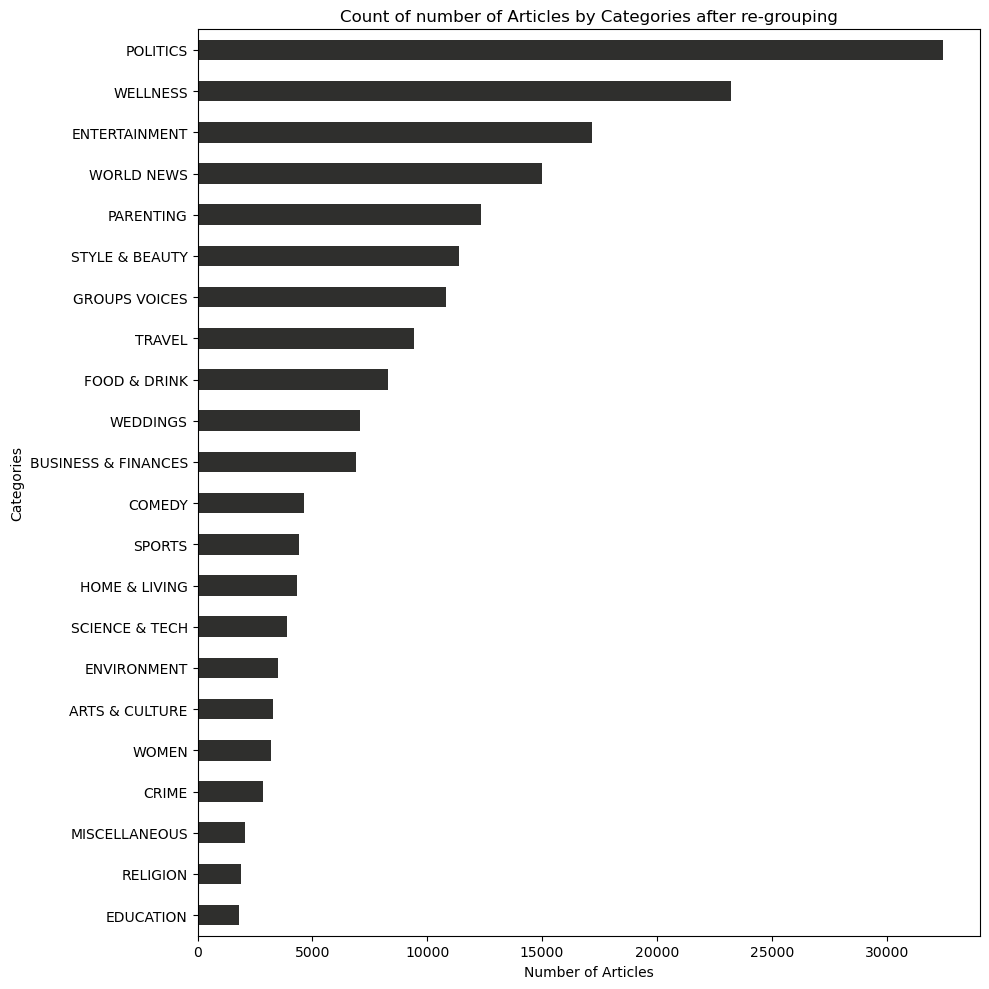

In [40]:
# Plot horizontal bar charts to visualize the count of each category:

plt.figure(figsize=(10, 10))
df_categories["category"].value_counts().sort_values().plot(
    kind="barh", color="#2F2F2D"
)
plt.xlabel("Number of Articles")
plt.ylabel("Categories")
plt.title("Count of number of Articles by Categories after re-grouping")
plt.tight_layout()
plt.show()

In [41]:
# Checking top 5 categories after combining similar categories
df_categories["category"].value_counts().sort_values(ascending=False).head(5)

POLITICS         32440
WELLNESS         23205
ENTERTAINMENT    17178
WORLD NEWS       14982
PARENTING        12346
Name: category, dtype: int64

Politics has the highest number of articles followed by Wellness and Entertainment. On the contrary, Religion, Education, and U.S. news have the least number of articles among all the categories.

## Understanding word distribution in our categories

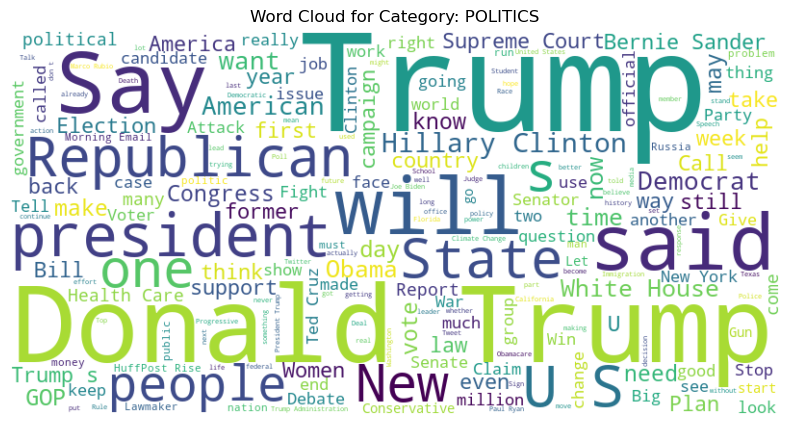

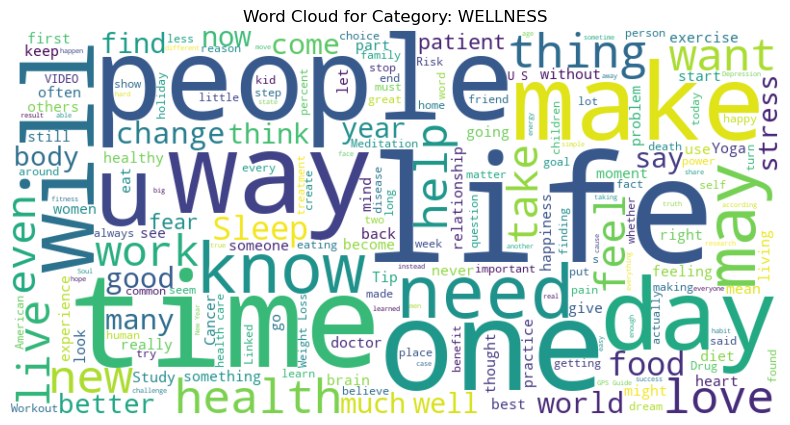

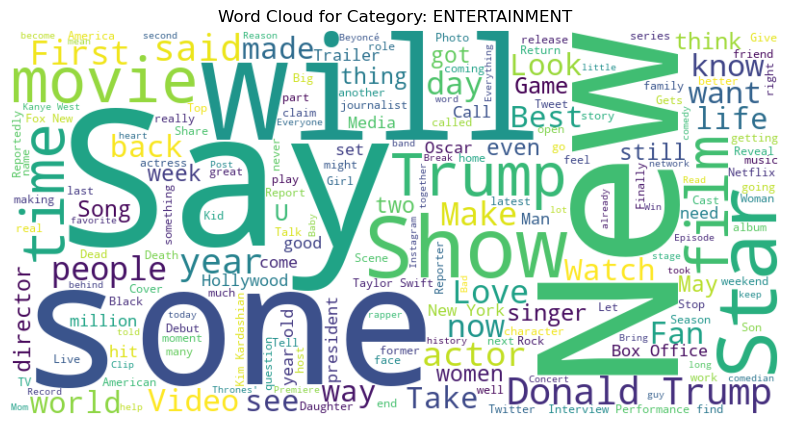

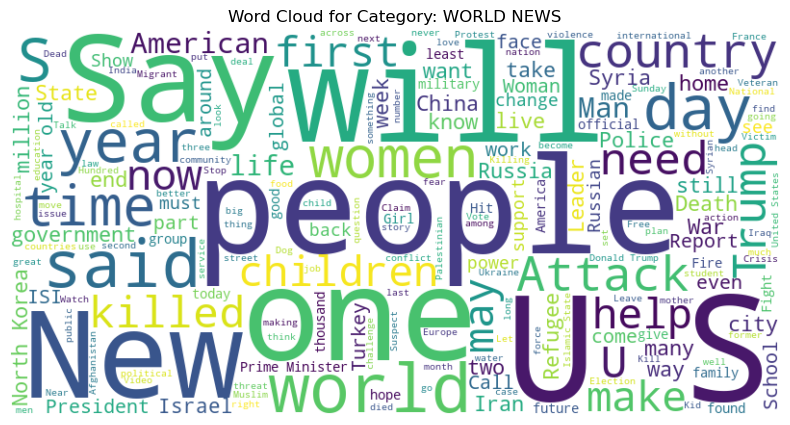

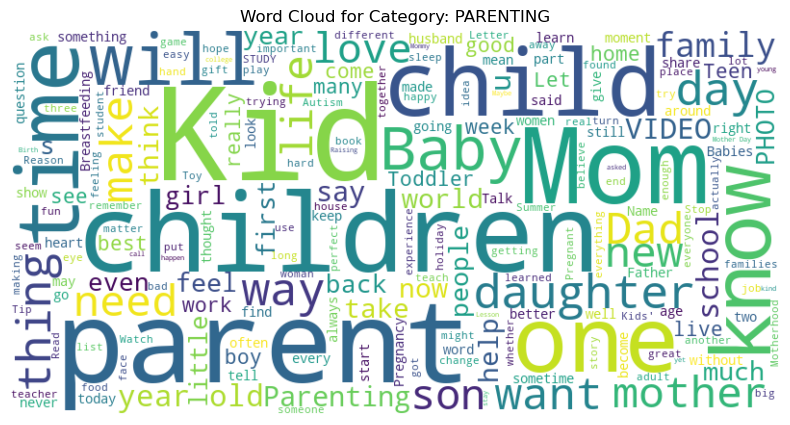

In [12]:
# getting top 5 categories by count of rows
top_categories = df_categories['category'].value_counts().head(5).index

# Create a word cloud for each top category
for category in top_categories:
    # Get all article texts for the current category
    category_texts = df_categories[df_categories['category'] == category]['article_text'].values
    
    # Combine all article texts into one string
    combined_text = ' '.join(category_texts)
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()


The word cloud shows a great representation of words in our categories. For example, Parenting category has high indexing words such as child, children, kid, baby, daughter etc. From modelling perspective, these are basically features (X) that inform us about the target category (y).

## Tokenizers and Vectorizers

In contrast to numerical data, which can be comprehended by both humans and machines, text data is primarily designed for human readability and poses a challenge for machines to understand directly. To address this challenge, we need to process each row (in our case, the 'article_text') by breaking it down into individual words, often referred to as tokens. Subsequently, we will employ techniques like count-vectorization, TF-IDF vectorization, or word2vec embeddings to convert these tokens into a numerical format that machines can work with effectively.

To begin, let's explore Tokenizers: (i) Stemming and (ii) Lemmatization. I've developed a set of functions and placed them in my GitHub directory, which we've already imported into our notebook (refer to the initial library import section at the top of the page).

### Tokenizer - Stemming

In [13]:
# defining a sample corpus to illustrate Custom Stemming tokenizer.
corpus = [
    'The quickesT brown foxes, jumped oveR the lazier dog!',
    'The laziest fox.  Leaped Over The quicker dogs?'
]

#stem_tokenizer is our custom tokenizer function that we import into our notebook
bagofwords = CountVectorizer(tokenizer=stem_tokenizer) 

bagofwords.fit(corpus)

# transform corpus into document-term matrix using the count vectorizer
dtm_stem = bagofwords.transform(corpus)

# display document-term matrix in DataFrame format
dtm_stem_df = pd.DataFrame(
    data = dtm_stem.toarray(), # .transform() method returns sparse matrix - need to cast it as an array
    columns = bagofwords.get_feature_names_out() # tokens are retrieved from .get_feature_names() method on the vectorizer 
)
dtm_stem_df

C:\Users\adhit\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,brown,dog,fox,jump,lazier,laziest,leap,quicker,quickest
0,1,1,1,1,1,0,0,0,1
1,0,1,1,0,0,1,1,1,0


In our example, we've created a sample text corpus to demonstrate the functionality of a custom stemming tokenizer. This tokenizer helps simplify words to their root form. As we can observe in our output, words like "foxes" were reduced to "fox," and "leaped" was transformed into "leap." However, words like "quicker" and "quickest" remained unchanged in our list of tokens.

### Tokenizer - Lemmatization

In [14]:
# # defining a sample corpus to illustrate Custom Lemmatization tokenizer.
corpus = [
    'The quickesT brown foxes, jumped oveR the lazier dog!',
    'The laziest fox.  Leaped Over The quicker dogs?'
]

# instantiate count vectorizer
cv = CountVectorizer(
    tokenizer = lem_tokenizer, # specify the name of the custom defined tokenizer WITHOUT brackets and arguments
    token_pattern = None # not necessary, but will throw you a warning if you don't change this
)

# fit count vectorizer to corpus
cv.fit(corpus)

# transform corpus into document-term matrix using the count vectorizer
dtm_lem = cv.transform(corpus)

# display document-term matrix in DataFrame format
dtm_lem_df = pd.DataFrame(
    data = dtm_lem.toarray(), # .transform() method returns sparse matrix - need to cast it as an array
    columns = cv.get_feature_names_out() # tokens are retrieved from .get_feature_names() method on the vectorizer 
)
dtm_lem_df


,brown,dog,fox,jump,lazy,leap,quick
0,1,1,1,1,1,0,1
1,0,1,1,0,1,1,1


Similar to Stemming, we have used the same corpus to demonstrate Lemmatization. 
This method reduces words to their base or dictionary form. As we see from our outputs, words like "foxes" were transformed into "fox," "jumped" became "jump," and "lazier" turned into "lazy." 

## Vectorizers: CountVectorizer vs TF-IDF vs Word2Vec

**CountVectorizer** counts the frequency of each word in a document by treating all words equally. In contrast, **TF-IDF** considers not only word frequency in a document but also how unique a word is across multiple documents, assigning higher weight to infrequent words that are important in a document.

### CountVectorizer on Stemming Tokenizer

For illustration purposes, I will fit and transform the countvectorizer on the whole dataset without splitting them into Train and Test sets. However, they will be split and fit_transformed in the next notebook for modelling(Part 3).

In [15]:
# 1. Instantiate 
bagofwords_cus_stem = CountVectorizer(
                             min_df=10,
                             max_features=500,
                             tokenizer=stem_tokenizer)

# 2. Fit 
bagofwords_cus_stem.fit(df_categories['article_text'])

# 3. Transform
cus_stem_transformed = bagofwords_cus_stem.transform(df_categories['article_text'])
cus_stem_transformed

C:\Users\adhit\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<189801x500 sparse matrix of type '<class 'numpy.int64'>'
	with 1418970 stored elements in Compressed Sparse Row format>

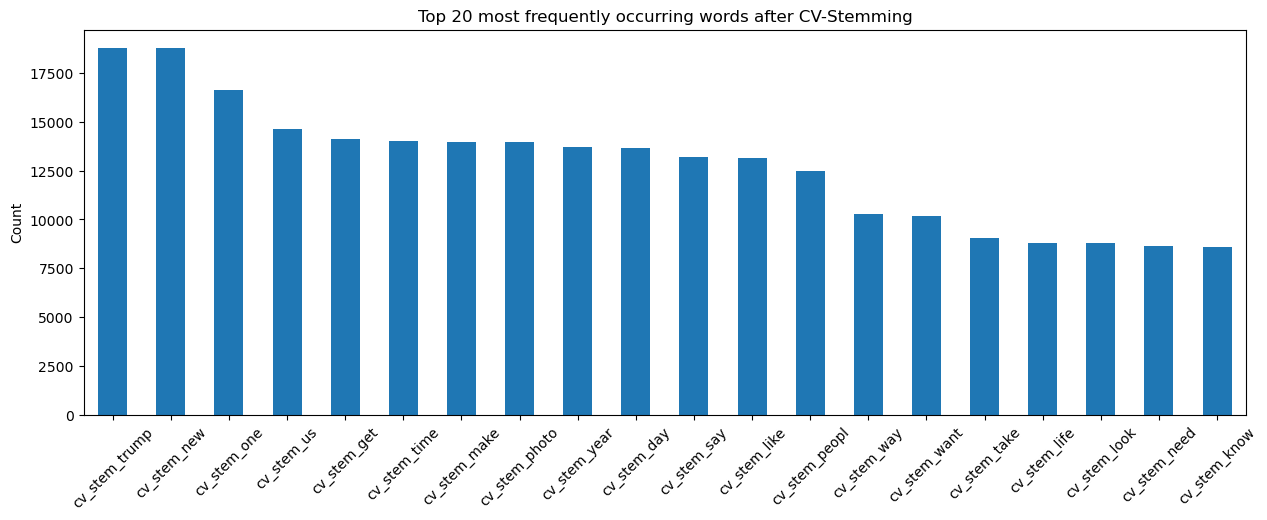

In [16]:
# Converting sparse matrix into dense array 
cus_stem_word_counts = pd.DataFrame(
    {"counts": cus_stem_transformed.toarray().sum(axis=0)},
    index= bagofwords_cus_stem.get_feature_names_out()
).sort_values("counts", ascending=False)

# Add "cv_stem_" before each index value
cus_stem_word_counts.index = "cv_stem_" + cus_stem_word_counts.index

# plotting top 20 words in "article text" by count in document-term matrix
cus_stem_word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words after CV-Stemming")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

These are the top 20 words in our "article_text" column based on their number of occurences.

### CountVectorizer on Lemmatization Tokenizer

In [17]:
# 1. Instantiate 
bagofwords_cus_lem = CountVectorizer(
                             min_df=10,
                             max_features=500,
                             tokenizer=lem_tokenizer)

# 2. Fit 
bagofwords_cus_lem.fit(df_categories['article_text'])

# 3. Transform
cus_lem_transformed = bagofwords_cus_lem.transform(df_categories['article_text'])
cus_lem_transformed


C:\Users\adhit\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<189801x500 sparse matrix of type '<class 'numpy.int64'>'
	with 1433951 stored elements in Compressed Sparse Row format>

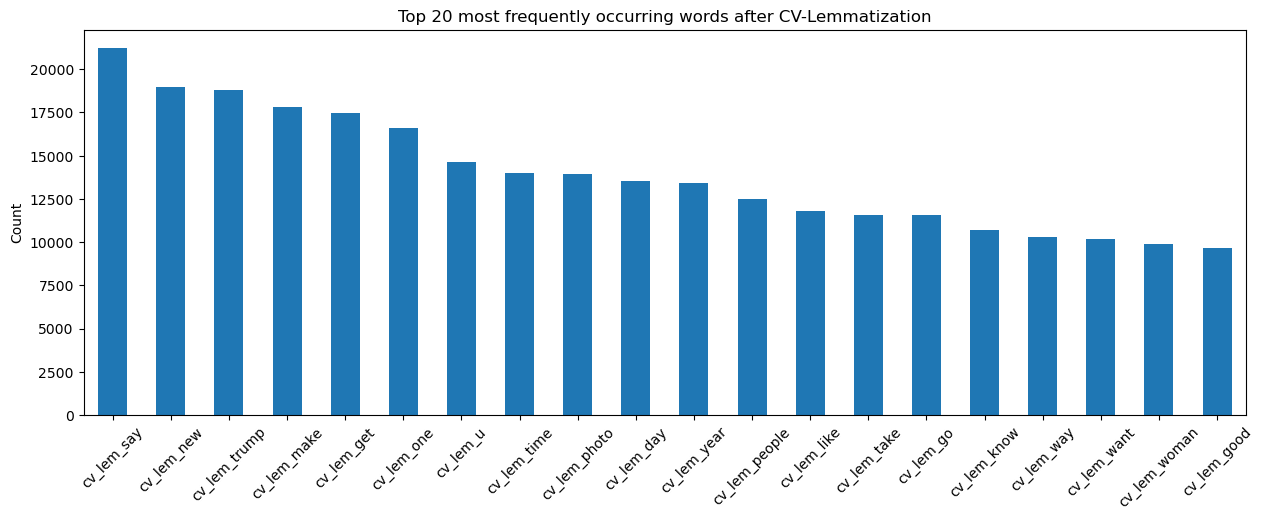

In [18]:
# Converting sparse matrix into dense array 
cus_lem_word_counts = pd.DataFrame(
    {"counts": cus_lem_transformed.toarray().sum(axis=0)},
    index= bagofwords_cus_lem.get_feature_names_out()
).sort_values("counts", ascending=False)

# Add "cus_lem_" before each index value
cus_lem_word_counts.index = "cv_lem_" + cus_lem_word_counts.index

# plotting top 20 words in "article text" by count in document-term matrix
cus_lem_word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words after CV-Lemmatization")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Based on the results, it becomes evident that the top 20 words vary between CV-Stemming and CV-Lemmatization. This discrepancy is not surprising since their tokenization approaches differ.

### Sentence2Vec

Additionally, there is another type of vectorizer called **Word2Vec** which is used as a form of transfer learning in NLP tasks. They are basically trained on large corpus of text data and the output is a collection of dense vectors representing words based on their semantic similarities in vector space. Also, **sentence2vec** is basically a mean of word embeddings in the given sentence. 

Below is an example to see it in action:

In [19]:
# sentence2vec embbeding example:

sentence = "I love tennis"

embedding = sentence2vec(sentence)

print(embedding)

[-0.09301758 -0.11938477  0.12866211  0.10070801 -0.05883789  0.00500488
  0.19384766 -0.17822266 -0.07928467  0.19482422  0.00689697 -0.05413818
  0.11065674  0.0144043  -0.10491943  0.10437012  0.13330078  0.29052734
  0.1385498  -0.0296936  -0.08618164  0.2770996  -0.01025391 -0.12451172
  0.03320312 -0.11376953 -0.01586914  0.18139648  0.11010742 -0.05749512
 -0.05895996  0.06996822 -0.07424927  0.04901123  0.06561279 -0.08105469
  0.21044922 -0.01171875  0.05334473  0.21679688  0.16601562 -0.15234375
  0.09057617  0.07452393 -0.02770996 -0.22509766  0.203125   -0.07019043
  0.04864502  0.25769043  0.05883789  0.18164062 -0.1940918  -0.06204224
  0.0871582  -0.07080078 -0.1048584  -0.18579102 -0.01407623 -0.1194458
  0.04150391  0.06921387 -0.1574707   0.08123779  0.02593994  0.09814453
  0.06298828  0.10334015  0.09533691  0.07910156  0.3203125  -0.03363037
 -0.01733398  0.02453613 -0.1468811   0.03930664 -0.16015625 -0.11938477
 -0.05761719  0.1184082  -0.3251953   0.09509277  0.

In [20]:
# shape of the embedding:
embedding.shape

(300,)

As evident, the sentence "I love tennis" is transformed into a (1, 300) vector. In a mathematical context, this sentence is embedded within a 300-dimensional space. Our objective was to convert text into numerical data, and this approach successfully achieves that by condensing it into 300 dimensions. This is in contrast to count vectorization and TF-IDF approaches, where the number of features or dimensions typically ranges from 20,000 or even more, depending on the dataset's size.

**Finding Similar sentences:** We can also use these embeddings to find other similar sentences in our dataset for the given input sentence.

In [21]:
# example finding similar sentences
sentence = """

I love this movie very much. 

The story was really dramatic and the movie was nicely picturized.

I would definitely watch it again soon.

"""

# Calculate the embedding of the input sentence
input_embedding = sentence2vec(sentence)

In [22]:
# Precompute embeddings for all other sentences
other_embeddings = [sentence2vec(other_sentence) for other_sentence in df_categories["article_text"]]

In [23]:
# Find top 5 similar sentences
similar_sentences = []
for other_embedding, other_sentence in zip(other_embeddings, df_categories["article_text"]):
    similarity = cosine_similarity([input_embedding], [other_embedding])[0][0]
    similar_sentences.append((other_sentence, similarity))

# Let's sort the similar sentences in descending order
similar_sentences.sort(key=lambda x: x[1], reverse=True)

# Print the top 5 similar sentences
for i, (similar_sentence, similarity) in enumerate(similar_sentences[:5], start=1):
    print(f"Top {i}: Similarity {similarity:.4f} - Sentence: {similar_sentence}")


Top 1: Similarity 0.8659 - Sentence: Just Seen It: The Family Movie Review Salim and I felt the film was a bit over the top and tonally inconsistent. I felt like the film wasn't sure what genre it
Top 2: Similarity 0.8596 - Sentence: 'Leonardo DiCaprio: The Movie' Looks A Little Intense But We'd Go See It In response to the question, "Can you cut nearly every Leonardo DiCaprio film into one mega-movie trailer that sort of seems
Top 3: Similarity 0.8524 - Sentence: Best Holiday Film: It's a Wonderful Life If you haven't seen It's a Wonderful Life, I'm sure you've seen at least one holiday TV episode mimicking it's storyline (however poorly). You want to know why it's copied so much? It's because it is the greatest (holiday?) film ever made. Here's why.
Top 4: Similarity 0.8499 - Sentence: 'Straight Outta Compton' Director Is 'Very Happy With The Accuracy' Of The Film "If E was here, he would like it so it's cool."
Top 5: Similarity 0.8493 - Sentence: Boeheim Stays in the Picture: Syracu

The above example shows how powerful the word embeddings are! We are able to capture the entire theme of the sentence just by using 300 Dimensions.

Let's also save the preprocessed data in a new csv file "preprocessed_categories.csv" so that we can access it easily when we move on to modeling in the next section

In [24]:
# Write the preprocessed DataFrame to a CSV file
df_categories.to_csv('preprocessed_categories.csv', index=False)

## Summary

In summary, we have transformed unstructured data into a structrured numerical data by implementing techniques like tokenization, vectorization and word embeddings. This is really important as our modelling success relies heavily on data pre-processing stage. In part 3, we will proceed to develop baseline models, fine-tune hyperparameters, and explore advance modeling techniques. Also, we will compare and assess model performance at each stage of our modelling.